# XCEPTION + DEC Model on Galaxy Zoo Dataset

This notebook loads the xception model and tries to extract features from the Xception Model for all the galaxy zoo images. Then it invokes a DEC model on top of the features extracted to perform the required clustering. This notebook acts as a step by step guide through the whole process and also as a way of performing the experiment for the current research of clustering galaxies.

### Importing required Libaries

Importing the required libraries and modules so that they can be used in the notebook

In [20]:
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
# loading the requirements for the Xception model
from keras.applications.xception import Xception
from keras.applications.xception import absolute_import, decode_predictions, preprocess_input
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
# Loading the DEC module cloned from github
from DEC.model import *
from DEC.metrics import *
from xception_dec_datagenerator import XceptionDataGenerator
# Importing the utilities
from utils.file_utils import *
# Use cv2 to actually load the images and resize
import cv2
from PIL import Image
# Using scikit-image  resize function for resizing the image from original size to 224 X 224
from skimage.transform import resize
# Train Test split from sklearn
from sklearn.model_selection import train_test_split
from shutil import copy2
# For visualization of images and for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Xception Model

First we load the Xception model into the computer memory using the Keras library. Because we are focusing on extracting features from the model we do not include the topmost layer. However we do use the imagenet weights for the model. Also because we want a 1-D vector form of the features we do use the pooling layer at the end.

In [21]:
input_tensor_shape = (224, 224, 3)
base_xception_model = Xception(weights = 'imagenet', input_shape = input_tensor_shape, include_top = False, pooling='avg')
base_xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

The input shape of our base xception model is: 224 X 224 X 3. That is a 3 channel square image with side 224 pixels.
The output shape of the base xception model is: 2048 X 1. It is a 1-D vector representing the features learned by the model

### Loading the Galaxy Zoo data

We now start loading the galaxy zoo data into memory. First we load the label file and then start loading the corresponding images such that we can assign the corresponding label to them

In [5]:
all_labels = pd.read_csv(f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1/training_solutions_rev1.csv')
all_labels.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [31]:
# Assuming the follwing column names:
elliptical_galaxy_col_name = 'Class1.1'
spiral_galaxy_col_name = 'Class1.2'

# elliptical_galaxy_ids = pd.Series(all_labels[all_labels[elliptical_galaxy_col_name] > all_labels[spiral_galaxy_col_name]]['GalaxyID'], dtype=str)
elliptical_galaxy_ids = pd.Series(all_labels[all_labels[elliptical_galaxy_col_name] >= 0.5]['GalaxyID'], dtype=str)
# spiral_galaxy_ids = pd.Series(all_labels[all_labels[spiral_galaxy_col_name] > all_labels[elliptical_galaxy_col_name]]['GalaxyID'], dtype=str)
spiral_galaxy_ids = pd.Series(all_labels[all_labels[spiral_galaxy_col_name] > 0.5]['GalaxyID'], dtype=str)

In [19]:
# Finding the number of images for each type of galaxy
print(f'Number Elliptical Galaxies: {elliptical_galaxy_ids.shape[0]}')
print(f'Number Spiral Galaxies: {spiral_galaxy_ids.shape[0]}')

Number Elliptical Galaxies: 25868
Number Spiral Galaxies: 34105


### Elliptical Galaxy

#### Visualization

In [8]:
elliptical_galaxy_ids.head()

2    100053
3    100078
4    100090
5    100122
6    100123
Name: GalaxyID, dtype: int64

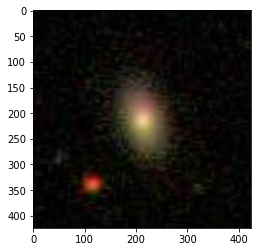

In [9]:
# Not using cv2 because it reads the image channels in a reverse order (BGR instead of RGB)
# elliptical_image = cv2.imread(f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1/100053.jpg')
elliptical_image = Image.open(f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1/100053.jpg')
plt.imshow(elliptical_image)

#### Features from the model

In [10]:
# First finding the input shape of the image
print(f'Original Image Size: {np.array(elliptical_image).shape}')
ellip_image_arr = resize(np.array(elliptical_image), input_tensor_shape)
print(f'Resized Image Size: {ellip_image_arr.shape}')

Original Image Size: (424, 424, 3)
Resized Image Size: (224, 224, 3)


C:\Users\Saksham\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Saksham\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [11]:
ellip_predications = base_xception_model.predict(ellip_image_arr.reshape((-1,) + input_tensor_shape))
ellip_predications

array([[1.2814113e-01, 5.2720916e-05, 0.0000000e+00, ..., 1.8458253e-01,
        1.0656949e-02, 0.0000000e+00]], dtype=float32)

### Spiral Galaxy

#### Visualization

In [12]:
spiral_galaxy_ids.head()

0     100008
1     100023
8     100134
9     100143
10    100150
Name: GalaxyID, dtype: int64

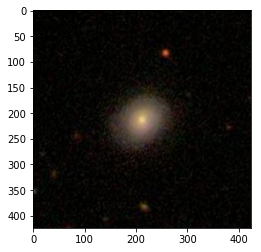

In [13]:
# Not using cv2 because it reads the image channels in a reverse order (BGR instead of RGB)
# spiral_image = cv2.imread(f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1/100008.jpg')
spiral_image = Image.open(f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1/100008.jpg')
plt.imshow(spiral_image)

#### Features from the model

In [14]:
# First finding the input shape of the image
print(f'Original Image Size: {np.array(spiral_image).shape}')
spiral_image_arr = resize(np.array(spiral_image), input_tensor_shape)
print(f'Resized Image Size: {spiral_image_arr.shape}')

Original Image Size: (424, 424, 3)
Resized Image Size: (224, 224, 3)


C:\Users\Saksham\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Saksham\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [15]:
spiral_predications = base_xception_model.predict(spiral_image_arr.reshape((-1,) + input_tensor_shape))
spiral_predications

array([[0.21515645, 0.        , 0.        , ..., 0.28888887, 0.00184119,
        0.        ]], dtype=float32)

### Data Validation

Validate whether all the images are in the required place of the training and the testing directories. Make sure we copy all the required images from the galaxy zoo data lake to the correct place and then define all the generators

In [22]:
data_lake_path = f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1/'
print(exist_directory(data_lake_path))
training_directory_path = f'../data/temp_xception_clustering/training/'
testing_directory_path = f'../data/temp_xception_clustering/testing/'
print(exist_directory(training_directory_path), exist_directory(testing_directory_path))

True
True True


In [37]:
# Get file names for the different types of galaxies from the dataframe that are also present in the dataset
image_extension = '.jpg'
all_image_files = get_file_nms(data_lake_path, image_extension)
len(all_image_files)
common_spiral_galaxy_ids = list(set(spiral_galaxy_ids).intersection(all_image_files))
common_elliptical_galaxy_ids = list(set(elliptical_galaxy_ids).intersection(all_image_files))
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of common Elliptical Galaxies: {len(common_elliptical_galaxy_ids)}')
print(f'Number of common Spiral Galaxies: {len(common_spiral_galaxy_ids)}')

Number of common Elliptical Galaxies: 25868
Number of common Spiral Galaxies: 34105


In [34]:
# Getting the files already in the training and testing folders respectively
spiral_training_directory_path = construct_path(training_directory_path, 'spiral')
elliptical_training_directory_path = construct_path(training_directory_path, 'elliptical')
spiral_testing_directory_path = construct_path(testing_directory_path, 'spiral')
elliptical_testing_directory_path = construct_path(testing_directory_path, 'elliptical')
elliptical_training_files = get_file_nms(elliptical_training_directory_path, image_extension)
spiral_training_files = get_file_nms(spiral_training_directory_path, image_extension)
elliptical_testing_files = get_file_nms(elliptical_testing_directory_path, image_extension)
spiral_testing_files = get_file_nms(spiral_testing_directory_path, image_extension)
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of already present Training Elliptical Galaxies: {len(elliptical_training_files)}')
print(f'Number of already present Training Spiral Galaxies: {len(spiral_training_files)}')
print(f'Number of already present Training Elliptical Galaxies: {len(elliptical_testing_files)}')
print(f'Number of already present Training Spiral Galaxies: {len(spiral_testing_files)}')

Number of already present Training Elliptical Galaxies: 0
Number of already present Training Spiral Galaxies: 0
Number of already present Training Elliptical Galaxies: 0
Number of already present Training Spiral Galaxies: 0


In [42]:
# Splitting the data into training and testing split
train_galaxy_ids_elliptical, test_galaxy_ids_elliptical = train_test_split(common_elliptical_galaxy_ids, test_size=0.2)
train_galaxy_ids_spiral, test_galaxy_ids_spiral = train_test_split(common_spiral_galaxy_ids, test_size=0.2)

In [45]:
%%time
# Iterating to copy the data
for file_name in set(train_galaxy_ids_elliptical) - elliptical_training_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(elliptical_training_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)

for file_name in set(test_galaxy_ids_elliptical) - elliptical_testing_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(elliptical_testing_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)
print('Hello')    
for file_name in set(train_galaxy_ids_spiral) - spiral_training_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(spiral_training_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)
print('Hello')    
for file_name in set(test_galaxy_ids_spiral) - spiral_testing_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(spiral_testing_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)
print('Hello')

Hello
Hello
Hello
Wall time: 13min 41s


### Data Generators

Defining the keras data generators to iterate through all the images and then essentially help in extracting the features from the images

In [74]:
%%time
generator_batch_size = 32
image_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, rescale=1./255)
training_generator = image_generator.flow_from_directory(training_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)
testing_generator = image_generator.flow_from_directory(testing_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)

Found 2000 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Wall time: 211 ms


In [75]:
n_train_examples = 640
train_features = np.zeros((n_train_examples, 2048))
train_labels = np.zeros(n_train_examples, dtype=int)
i = 0
for inputs_batch, labels_batch in training_generator:
    features_batch = base_xception_model.predict(inputs_batch)
    train_features[i * generator_batch_size : (i + 1) * generator_batch_size] = features_batch
    train_labels[i * generator_batch_size : (i + 1) * generator_batch_size] = labels_batch
    i += 1
    if i * generator_batch_size >= n_train_examples:
        break

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Saksham\Anaconda3\lib\site-packages\keras_prepr

In [76]:
train_features.shape

(640, 2048)

In [69]:
# other type of feature generation
#%%time
#number_training_samples = len(training_generator.filenames)
#number_testing_samples = len(testing_generator.filenames)
#train_features = base_xception_model.predict_generator(training_generator, steps=10)

### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [77]:
# Defining our DEC model
dec_model = DEC([2048, 1024, 512, 512, 256])
dec_model.pretrain(train_features, train_labels, epochs=200)

...Pretraining...
Epoch 1/50
640/640 [==============================] - 1s 2ms/step - loss: 0.0417
        |==>  acc: 0.6141,  nmi: 0.0408  <==|
Epoch 2/50
256/640 [===========>..................] - ETA: 0s - loss: 0.0415

C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


640/640 [==============================] - 0s 565us/step - loss: 0.0308
Epoch 3/50
640/640 [==============================] - 0s 563us/step - loss: 0.0243
Epoch 4/50
640/640 [==============================] - 0s 586us/step - loss: 0.0179
Epoch 5/50
640/640 [==============================] - 0s 560us/step - loss: 0.0139
Epoch 6/50
640/640 [==============================] - 0s 549us/step - loss: 0.0131
        |==>  acc: 0.6312,  nmi: 0.0503  <==|
Epoch 7/50
256/640 [===========>..................] - ETA: 0s - loss: 0.0127

C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


640/640 [==============================] - 0s 564us/step - loss: 0.0126
Epoch 8/50
640/640 [==============================] - 0s 643us/step - loss: 0.0123
Epoch 9/50
640/640 [==============================] - 0s 652us/step - loss: 0.0120
Epoch 10/50
640/640 [==============================] - 0s 593us/step - loss: 0.0118
Epoch 11/50
640/640 [==============================] - 0s 664us/step - loss: 0.0117
        |==>  acc: 0.6594,  nmi: 0.0752  <==|
Epoch 12/50
256/640 [===========>..................] - ETA: 0s - loss: 0.0117

C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


640/640 [==============================] - 0s 568us/step - loss: 0.0116
Epoch 13/50
640/640 [==============================] - 0s 608us/step - loss: 0.0116
Epoch 14/50
640/640 [==============================] - 0s 643us/step - loss: 0.0115
Epoch 15/50
640/640 [==============================] - 0s 640us/step - loss: 0.0113
Epoch 16/50
640/640 [==============================] - 0s 644us/step - loss: 0.0112
        |==>  acc: 0.6766,  nmi: 0.1271  <==|
Epoch 17/50
256/640 [===========>..................] - ETA: 0s - loss: 0.0114

C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


640/640 [==============================] - 0s 599us/step - loss: 0.0109
Epoch 18/50
640/640 [==============================] - 0s 625us/step - loss: 0.0106
Epoch 19/50
640/640 [==============================] - 0s 584us/step - loss: 0.0102
Epoch 20/50
640/640 [==============================] - 0s 639us/step - loss: 0.0099
Epoch 21/50
640/640 [==============================] - 0s 669us/step - loss: 0.0097
        |==>  acc: 0.6891,  nmi: 0.1198  <==|
Epoch 22/50
256/640 [===========>..................] - ETA: 0s - loss: 0.0095

C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


640/640 [==============================] - 0s 614us/step - loss: 0.0095
Epoch 23/50
640/640 [==============================] - 0s 590us/step - loss: 0.0093
Epoch 24/50
640/640 [==============================] - 0s 637us/step - loss: 0.0089
Epoch 25/50
640/640 [==============================] - 0s 622us/step - loss: 0.0085
Epoch 26/50
640/640 [==============================] - 0s 630us/step - loss: 0.0082
        |==>  acc: 0.5156,  nmi: 0.0007  <==|
Epoch 27/50
256/640 [===========>..................] - ETA: 0s - loss: 0.0077

C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


640/640 [==============================] - 0s 602us/step - loss: 0.0078
Epoch 28/50
640/640 [==============================] - 0s 603us/step - loss: 0.0076
Epoch 29/50
640/640 [==============================] - 0s 587us/step - loss: 0.0074
Epoch 30/50
640/640 [==============================] - 0s 612us/step - loss: 0.0073
Epoch 31/50
640/640 [==============================] - 0s 606us/step - loss: 0.0072
        |==>  acc: 0.6859,  nmi: 0.1034  <==|
Epoch 32/50
256/640 [===========>..................] - ETA: 0s - loss: 0.0071

C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


640/640 [==============================] - 0s 586us/step - loss: 0.0071
Epoch 33/50
640/640 [==============================] - 0s 563us/step - loss: 0.0070
Epoch 34/50
640/640 [==============================] - 0s 570us/step - loss: 0.0069
Epoch 35/50
640/640 [==============================] - 0s 566us/step - loss: 0.0068
Epoch 36/50
640/640 [==============================] - 0s 626us/step - loss: 0.0068
        |==>  acc: 0.5266,  nmi: 0.0020  <==|
Epoch 37/50
256/640 [===========>..................] - ETA: 0s - loss: 0.0070

C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


640/640 [==============================] - 0s 573us/step - loss: 0.0066
Epoch 38/50
640/640 [==============================] - 0s 619us/step - loss: 0.0065
Epoch 39/50
640/640 [==============================] - 0s 594us/step - loss: 0.0063
Epoch 40/50
640/640 [==============================] - 0s 660us/step - loss: 0.0061
Epoch 41/50
640/640 [==============================] - 0s 638us/step - loss: 0.0060
        |==>  acc: 0.6703,  nmi: 0.1072  <==|
Epoch 42/50
256/640 [===========>..................] - ETA: 0s - loss: 0.0059

C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


640/640 [==============================] - 0s 633us/step - loss: 0.0059
Epoch 43/50
640/640 [==============================] - 0s 657us/step - loss: 0.0058
Epoch 44/50
640/640 [==============================] - 0s 637us/step - loss: 0.0056
Epoch 45/50
640/640 [==============================] - 0s 606us/step - loss: 0.0055
Epoch 46/50
640/640 [==============================] - 0s 666us/step - loss: 0.0054
        |==>  acc: 0.6547,  nmi: 0.1016  <==|
Epoch 47/50
256/640 [===========>..................] - ETA: 0s - loss: 0.0055

C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


640/640 [==============================] - 0s 575us/step - loss: 0.0053
Epoch 48/50
640/640 [==============================] - 0s 647us/step - loss: 0.0053
Epoch 49/50
640/640 [==============================] - 0s 639us/step - loss: 0.0053
Epoch 50/50
640/640 [==============================] - 0s 636us/step - loss: 0.0052
Pretraining time: 26s
Pretrained weights are saved to results/temp/ae_weights.h5


In [79]:
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
encoder_1 (Dense)            (None, 512)               524800    
_________________________________________________________________
encoder_2 (Dense)            (None, 512)               262656    
_________________________________________________________________
encoder_3 (Dense)            (None, 256)               131328    
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                2560      
Total params: 3,019,520
Trainable params: 3,019,520
Non-trainable params: 0
_________________________________________________________________


In [80]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 100
Initializing cluster centers with k-means.


C:\Users\Saksham\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 0: acc = 0.22031, nmi = 0.09331, ari = 0.04116  ; loss= 0
saving model to: ./results/temp/DEC_model_0.h5
saving model to: ./results/temp/DEC_model_100.h5
Iter 140: acc = 0.19219, nmi = 0.09082, ari = 0.04151  ; loss= 0.06277
saving model to: ./results/temp/DEC_model_200.h5
Iter 280: acc = 0.19375, nmi = 0.08854, ari = 0.04089  ; loss= 0.11065
saving model to: ./results/temp/DEC_model_300.h5
saving model to: ./results/temp/DEC_model_400.h5
Iter 420: acc = 0.19688, nmi = 0.08695, ari = 0.04107  ; loss= nan
saving model to: ./results/temp/DEC_model_500.h5
Iter 560: acc = 0.20312, nmi = 0.08279, ari = 0.04175  ; loss= 0.17851
saving model to: ./results/temp/DEC_model_600.h5
Iter 700: acc = 0.22344, nmi = 0.08441, ari = 0.04407  ; loss= 0.20216
saving model to: ./results/temp/DEC_model_700.h5
saving model to: ./results/temp/DEC_model_800.h5
Iter 840: acc = 0.20312, nmi = 0.08538, ari = 0.04258  ; loss= nan
saving model to: ./results/temp/DEC_model_900.h5
Iter 980: acc = 0.21406, nmi = 

NameError: name 'y' is not defined